# 0. Install Dependencies and Bring in Data

In [ ]:
!pip install tensorflow pandas matplotlib scikit-learn

In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [3]:
df=pd.read_csv('train.csv')

In [4]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# 1. Preprocess

In [ ]:
!pip list

In [5]:
from tensorflow.keras.layers import TextVectorization

In [6]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [7]:
MAX_FEATURES = 200000 # number of words in the vocab

In [8]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Suppress TensorFlow warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Your existing code

vectorizer = TextVectorization(
    max_tokens=MAX_FEATURES,
    output_sequence_length=1800,
    output_mode='int'
)


In [9]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [10]:
vectorizer.adapt(X.values)

In [11]:
vectorized_text = vectorizer(X.values)

In [12]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [13]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

# 2. Create Sequential Model

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [15]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [16]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [18]:
history = model.fit(train, epochs=1, validation_data=val)

6981/6981 [==============================] - 8638s 1s/step - loss: 0.0622 - val_loss: 0.0461


In [19]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

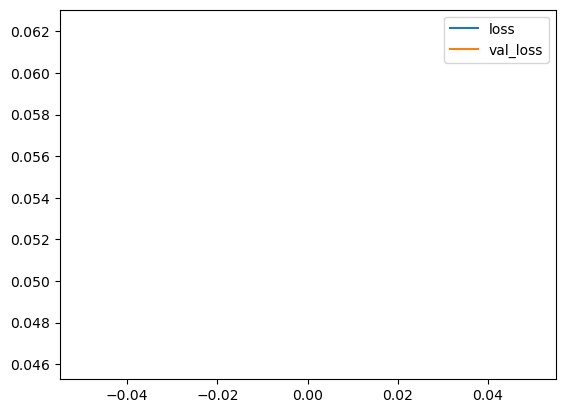

In [20]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# 3. Make Predictions

In [21]:
input_text = vectorizer('You freaking suck! I am going to hit you.')

In [22]:
res = model.predict(np.array([input_text]))

1/1 [==============================] - 1s 885ms/step


In [23]:
(res > 0.5).astype(int)

array([[1, 0, 1, 0, 1, 0]])

In [24]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [25]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 0s 123ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [26]:
res.shape

(1, 6)

# 4. Evaluate Model

In [44]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [45]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [47]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 313ms/step


1/1 [==============================] - 0s 313ms/step


1/1 [==============================] - 0s 313ms/step


1/1 [==============================] - 0s 313ms/step


1/1 [==============================] - 0s 306ms/step


1/1 [==============================] - 0s 304ms/step


1/1 [==============================] - 0s 315ms/step


In [48]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.7994269132614136, Recall:0.7257356643676758, Accuracy:0.4947183132171631


# 5. Test and Gradio

In [57]:
import tensorflow as tf
import gradio as gr

In [58]:
pip install gradio

Note: you may need to restart the kernel to use updated packages.


In [59]:
import gradio as gr




In [60]:
model.save('toxicity.h5')

In [61]:
model = tf.keras.models.load_model('toxicity.h5')

In [62]:
input_str = vectorizer('hey i freaken hate you!')

In [63]:
res = model.predict(np.expand_dims(input_str,0))

1/1 [==============================] - 3s 3s/step


In [64]:
res

array([[0.8025582 , 0.0388784 , 0.4507446 , 0.02458359, 0.45213258,
        0.10234343]], dtype=float32)

In [65]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [77]:
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

In [78]:
import httpx
from httpcore import ConnectTimeout

try:
    httpx.post(interface.launch(share=True), timeout=10)  # or a higher value
except ConnectTimeout:
    print("Analytics request timed out. Please check your network connection.")



Running on local URL:  http://127.0.0.1:7867

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


2024/01/16 19:55:21 [W] [service.go:132] login to server failed: dial tcp 44.237.78.176:7000: i/o timeout


TypeError: Invalid type for url.  Expected str or httpx.URL, got <class 'gradio.utils.TupleNoPrint'>: 